# 0. Load Packages and Define Helper Functions

In [43]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/BT5153_Project'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/BT5153_Project
/content/gdrive/My Drive/BT5153_Project


In [44]:
#import packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, uniform
from preprocessing import preprocess_df, get_amenities
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. Load and Preprocess

In [45]:
data = pd.read_csv('data/listings.csv.gz')
df = preprocess_df(data = data, verbose = True)

Columns dropped ['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_about', 'host_picture_url', 'calendar_last_scraped', 'license', 'host_url', 'host_thumbnail_url', 'host_verifications', 'name', 'description', 'neighborhood_overview', 'host_name', 'calendar_updated', 'bathrooms', 'host_neighbourhood', 'neighbourhood', 'host_listings_count', 'beds', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'neighbourhood_cleansed']
Before removing inactive listings, length = 66641
After removing inactive listings, length = 33046
After removing price = 0 listings, length = 33037
Features bathroom_num and bathroom_sharing extracted.
Int and float mv filled with 0, object m

In [46]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [47]:
df = get_amenities(data = df, 
                   num_amenities =80, # best is to call 80 amenities and select from there
                  verbose = True)

[('wifi', 32096), ('essentials', 31414), ('smoke alarm', 30603), ('heating', 29750), ('kitchen', 29321), ('hangers', 28388), ('long term stays allowed', 28070), ('iron', 27868), ('washer', 26852), ('hair dryer', 26387), ('hot water', 25305), ('shampoo', 23394), ('carbon monoxide alarm', 22656), ('dedicated workspace', 22473), ('dishes and silverware', 21126), ('cooking basics', 20499), ('refrigerator', 20424), ('bed linens', 18340), ('tv', 17925), ('microwave', 17588), ('oven', 17256), ('stove', 15436), ('dryer', 14012), ('first aid kit', 12522), ('fire extinguisher', 12352), ('coffee maker', 11651), ('dishwasher', 11275), ('private entrance', 9889), ('extra pillows and blankets', 9725), ('luggage dropoff allowed', 8066), ('host greets you', 7248), ('lockbox', 7143), ('bathtub', 7013), ('elevator', 6878), ('free parking on premises', 6310), ('shower gel', 6301), ('paid parking off premises', 5864), ('hot water kettle', 5738), ('backyard', 5698), ('free street parking', 5674), ('lock on

In [48]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_outdoor dining area,amenities_children’s books and toys,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_private fenced garden or backyard,amenities_building staff,amenities_paid street parking off premises,amenities_nespresso machine
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,1,0,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
14,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df['room_type'].value_counts()

Entire home/apt    20083
Private room       12646
Shared room          142
Hotel room           139
Name: room_type, dtype: int64

# 2. Feature Engineering

## 2.1 Host Duration

In [50]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

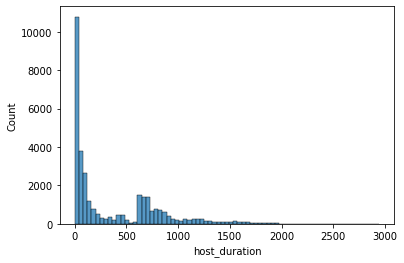

In [51]:
sns.histplot(df['host_duration'])
plt.show()

## 2.2 managed_property

- Binary (0,1). 1 if properties managed by host id exceed the 95th percentile.

In [52]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
print('*****EXTRACT PROPERTIES MANAGED BY HOST ID *****')
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0
*****EXTRACT PROPERTIES MANAGED BY HOST ID *****


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [53]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    22496
1    10514
Name: prop_managed, dtype: int64

## 2.3 Occupancy Rate

- short term proxy: avail30
- mid term proxy: avail60-90
- long term proxy: avail365

In [54]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,33010.000000,33010.000000,33010.000000,33010.000000
mean,6.882187,18.561527,31.615177,121.371191
std,9.251464,20.881292,33.341793,134.103803
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,17.000000,66.000000
75%,12.000000,37.000000,65.000000,248.000000
max,30.000000,60.000000,90.000000,365.000000


In [55]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [56]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_private fenced garden or backyard',
       'amenities_building staff',
       'amenities_paid street parking off premises',
       'amenities_nespresso machine', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

## 2.4 Location Variables

In [57]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance','neighbourhood']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance,neighbourhood
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0,Kensington and Chelsea
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0,Barnet
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0,Barnet
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0,Barnet
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0,Hammersmith and Fulham


## 2.5 Sentiment

In [58]:
############## Add sentiment features #################
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')
# df_sentiment = df_sentiment.groupby('listing_id').mean()
# df_sentiment = df_sentiment.reset_index()
df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,neighbourhood,Unnamed: 0,id_y,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,Kensington and Chelsea,1.0,8.029375e+07,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,Barnet,3.0,8.898858e+07,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,Barnet,10.0,1.066726e+08,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,Barnet,16621.0,4.596262e+08,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,Hammersmith and Fulham,7.0,3.235218e+08,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310


# 3. Recommender

## 3.1 Select Relevant Features

In [59]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.rename(columns = {'id_x':'id'})

In [60]:
df.columns.tolist()

['id',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities_h

In [61]:
features_selected = [    'id',
                         'host_id',
                         'price',
                         'latitude',
                         'longitude',
                         'property_type',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'review_scores_rating',
                         'review_scores_location',
                         'bathroom_num',
                         'bathroom_sharing',
                         'amenities_wifi',
                         'amenities_essentials',
                         'amenities_heating',
                         'amenities_kitchen',
                         'amenities_washer',
                         'amenities_cookingbasics',
                         'amenities_breakfast',
                         'amenities_airconditioning',
                         'amenities_privatefencedgardenorbackyard',
                         'station',
                         'station_dist',
                         'walking_distance']

extra_amenities_and_scores = ['amenities_smokealarm',
                              'amenities_hangers',
                              'amenities_longtermstaysallowed',
                              'amenities_iron',
                              'amenities_hairdryer',
                              'amenities_hotwater',
                              'amenities_shampoo',
                              'amenities_carbonmonoxidealarm',
                              'amenities_dedicatedworkspace',
                              'amenities_dishesandsilverware',
                              'amenities_refrigerator',
                              'amenities_bedlinens',
                              'amenities_tv',
                              'amenities_microwave',
                              'amenities_oven',
                              'amenities_stove',
                              'amenities_dryer',
                              'amenities_firstaidkit',
                              'amenities_fireextinguisher',
                              'amenities_coffeemaker',
                              'amenities_dishwasher',
                              'amenities_privateentrance',
                              'amenities_extrapillowsandblankets',
                              'amenities_luggagedropoffallowed',
                              'amenities_hostgreetsyou',
                              'amenities_lockbox',
                              'amenities_bathtub',
                              'amenities_elevator',
                              'amenities_freeparkingonpremises',
                              'amenities_showergel',
                              'amenities_paidparkingoffpremises',
                              'amenities_hotwaterkettle',
                              'amenities_freestreetparking',
                              'amenities_lockonbedroomdoor',
                              'amenities_cabletv',
                              'amenities_patioorbalcony',
                              'amenities_freezer',
                              'amenities_tvwithstandardcable',
                              'amenities_cleaningproducts',
                              'amenities_toaster',
                              'amenities_diningtable',
                              'amenities_wineglasses',
                              'amenities_roomdarkeningshades',
                              'amenities_bodysoap',
                              'amenities_dryingrackforclothing',
                              'amenities_singlelevelhome',
                              'amenities_securitycamerasonproperty',
                              'amenities_conditioner',
                              'amenities_indoorfireplace',
                              'amenities_portablefans',
                              'amenities_ethernetconnection',
                              'amenities_outdoorfurniture',
                              'amenities_laundromatnearby',
                              'amenities_packnplaytravelcrib',
                              'amenities_crib',
                              'amenities_highchair',
                              'amenities_bakingsheet',
                              'amenities_bbqgrill',
                              'amenities_paidparkingonpremises',
                              'amenities_privatepatioorbalcony',
                              'amenities_centralheating',
                              'amenities_outdoordiningarea',
                              'amenities_childrensbooksandtoys',
                              'amenities_cleaningbeforecheckout',
                              'amenities_clothingstorage',
                              'amenities_clothingstoragecloset',
                              'amenities_minifridge',
                              'amenities_backyard',
                              'review_scores_accuracy',
                              'review_scores_cleanliness',
                              'review_scores_checkin',
                              'review_scores_communication',
                              'review_scores_value',
                              'reviews_per_month',]

In [62]:
df = df[features_selected]
df

,id,host_id,price,latitude,longitude,property_type,room_type,accommodates,bedrooms,review_scores_rating,...,amenities_heating,amenities_kitchen,amenities_washer,amenities_cookingbasics,amenities_breakfast,amenities_airconditioning,amenities_privatefencedgardenorbackyard,station,station_dist,walking_distance
0,15400,60302,75.0,51.487800,-0.168130,Entire rental unit,Entire home/apt,2,1.0,4.79,...,1,1,1,1,0,1,0,South Kensington,805.406363,0.0
1,25123,103583,29.0,51.574380,-0.210810,Private room in residential home,Private room,2,1.0,4.78,...,1,1,1,0,0,0,0,Brent Cross,302.665825,1.0
2,41311,103583,25.0,51.574000,-0.210580,Private room in residential home,Private room,2,1.0,4.90,...,1,1,1,0,0,0,0,Brent Cross,346.564965,1.0
3,19516454,103583,23.0,51.574660,-0.209160,Private room in residential home,Private room,1,1.0,4.93,...,1,1,1,1,0,0,0,Brent Cross,361.025714,1.0
4,38610,165579,190.0,51.507010,-0.233620,Entire townhouse,Entire home/apt,8,4.0,4.86,...,1,1,1,1,0,0,1,Shepherds Bush Market,449.743591,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33005,53606541,52745934,408.0,51.513224,-0.176721,Entire condominium (condo),Entire home/apt,6,3.0,5.00,...,1,1,1,1,0,0,0,Lancaster Gate,173.363797,3.0
33006,53618701,433572694,131.0,51.509252,-0.268434,Entire condominium (condo),Entire home/apt,4,1.0,5.00,...,1,1,1,1,0,0,0,Acton Central,351.705000,1.0
33007,53629457,314377938,40.0,51.451325,-0.121519,Private room in rental unit,Private room,1,1.0,2.00,...,0,1,1,0,0,0,0,Herne Hill,1350.655529,0.0
33008,53656459,50739127,36.0,51.604068,-0.479865,Private room in residential home,Private room,2,1.0,1.00,...,1,1,1,1,1,1,0,Northwood,3961.982801,0.0


In [63]:
df.columns

Index(['id', 'host_id', 'price', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'review_scores_rating',
       'review_scores_location', 'bathroom_num', 'bathroom_sharing',
       'amenities_wifi', 'amenities_essentials', 'amenities_heating',
       'amenities_kitchen', 'amenities_washer', 'amenities_cookingbasics',
       'amenities_breakfast', 'amenities_airconditioning',
       'amenities_privatefencedgardenorbackyard', 'station', 'station_dist',
       'walking_distance'],
      dtype='object')

In [64]:
#get a mapping of ids to index
full_mapping = pd.Series(df.index,index = df['id'])
full_mapping

id
15400           0
25123           1
41311           2
19516454        3
38610           4
            ...  
53606541    33005
53618701    33006
53629457    33007
53656459    33008
53673183    33009
Length: 33010, dtype: int64

## 3.2 Preprocessing and Normalisation

In [65]:
# since normalisation is going to happen, latitude and longitude need to be converted to cartesian plane
# https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature

df['x'] = np.cos(df['latitude']) * np.cos(df['longitude'])
df['y'] = np.cos(df['latitude']) * np.sin(df['longitude'])
df['z'] = np.sin(df['latitude'])

df.drop(['latitude', 'longitude'], axis = 1, inplace = True)
df

,id,host_id,price,property_type,room_type,accommodates,bedrooms,review_scores_rating,review_scores_location,bathroom_num,...,amenities_cookingbasics,amenities_breakfast,amenities_airconditioning,amenities_privatefencedgardenorbackyard,station,station_dist,walking_distance,x,y,z
0,15400,60302,75.0,Entire rental unit,Entire home/apt,2,1.0,4.79,4.93,1.0,...,1,0,1,0,South Kensington,805.406363,0.0,0.336654,-0.057141,0.939893
1,25123,103583,29.0,Private room in residential home,Private room,2,1.0,4.78,4.45,1.5,...,0,0,0,0,Brent Cross,302.665825,1.0,0.253183,-0.054179,0.965900
2,41311,103583,25.0,Private room in residential home,Private room,2,1.0,4.90,4.51,1.5,...,0,0,0,0,Brent Cross,346.564965,1.0,0.253554,-0.054197,0.965802
3,19516454,103583,23.0,Private room in residential home,Private room,1,1.0,4.93,4.90,1.5,...,1,0,0,0,Brent Cross,361.025714,1.0,0.253008,-0.053705,0.965973
4,38610,165579,190.0,Entire townhouse,Entire home/apt,8,4.0,4.86,4.75,2.0,...,1,0,0,1,Shepherds Bush Market,449.743591,3.0,0.314567,-0.074856,0.946279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33005,53606541,52745934,408.0,Entire condominium (condo),Entire home/apt,6,3.0,5.00,5.00,2.5,...,1,0,0,0,Lancaster Gate,173.363797,3.0,0.312520,-0.055811,0.948270
33006,53618701,433572694,131.0,Entire condominium (condo),Entire home/apt,4,1.0,5.00,5.00,1.0,...,1,0,0,0,Acton Central,351.705000,1.0,0.309724,-0.085197,0.947002
33007,53629457,314377938,40.0,Private room in rental unit,Private room,1,1.0,2.00,4.00,1.0,...,0,0,0,0,Herne Hill,1350.655529,0.0,0.372747,-0.045520,0.926816
33008,53656459,50739127,36.0,Private room in residential home,Private room,2,1.0,1.00,2.00,1.0,...,1,1,1,0,Northwood,3961.982801,0.0,0.204138,-0.106241,0.973160


In [66]:
#combine related features

df['amenities_ac_and_heating'] = (df['amenities_airconditioning'] + df['amenities_heating'])/2
df['amenities_cooking_and_kitchen'] = (df['amenities_cookingbasics'] + df['amenities_kitchen'])/2

df.drop(['amenities_airconditioning','amenities_heating','amenities_cookingbasics', 'amenities_kitchen'], axis = 1, inplace = True)

In [67]:
df.dtypes

id                                           int64
host_id                                      int64
price                                      float64
property_type                               object
room_type                                   object
accommodates                                 int64
bedrooms                                   float64
review_scores_rating                       float64
review_scores_location                     float64
bathroom_num                               float64
bathroom_sharing                            object
amenities_wifi                               int64
amenities_essentials                         int64
amenities_washer                             int64
amenities_breakfast                          int64
amenities_privatefencedgardenorbackyard      int64
station                                     object
station_dist                               float64
walking_distance                           float64
x                              

In [68]:
#drop columns that are relavant for results but are not being compared
df_no_ids = df.drop(['id','host_id','price'], axis = 1)

#one hot encode categorical columns
df_no_ids = pd.get_dummies(df_no_ids)

#normalise df for cosine similarity calculation (linear kernel only does dot product so we need to manually normalise)
normalizer = Normalizer()
df_no_ids = pd.DataFrame(normalizer.fit_transform(df_no_ids))

## 3.3 Define Helper Functions

In [69]:
#function to split df into smaller chunks so that RAM is not fully used

def create_split_dfs(airbnb_id, selected_df):

  #get the index value from the full mapping from df
  airbnb_index = full_mapping[airbnb_id]

  #create a df with only the row containing the airbnb id of choice and a df without it
  selected_row = selected_df.iloc[airbnb_index]
  df_new = selected_df.drop(airbnb_index, axis=0)  

  #split df without row of choice into 4
  df_split = np.array_split(df_new, 4)


  small_df_list = []

  #append the selected row to each df for comparison
  for d in df_split:
    small_df = d.reset_index(drop = True).append(selected_row, ignore_index = True)
    small_df_list.append(small_df)

  return small_df_list

In [70]:
#get top 10 airbnbs for a chunk in a df with ids and df without ids and with normalisation

def get_similar_airbnb(airbnb_id, similarity_matrix, selected_df, no_id_df):

  #get mapping for the small df selected and then find the airbnb id selected
  mapping = pd.Series(selected_df.index,index = selected_df['id'])
  airbnb_index = mapping[airbnb_id]

  #get similarity scores for all others in that df to selected airbnb and order descending
  similarity_score = list(enumerate(similarity_matrix[airbnb_index]))
  similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)

  #select top 10 (ignoring first because that will be the same one)
  similarity_score = similarity_score[1:11]

  #get indices of the highest similarity scores here
  airbnb_indices = [i[0] for i in similarity_score]

  #return a df with selected rows from main df and one without ids
  return  selected_df.iloc[airbnb_indices], no_id_df.iloc[airbnb_indices]

In [71]:
# get top 10 most similar airbnbs overall

def get_top_10(airbnb_id):

  #get index from main df from full mapping
  airbnb_index = full_mapping[airbnb_id]

  #get selected row from main df and one without id
  selected_row = df.iloc[airbnb_index]
  selected_row_no_id = df_no_ids.iloc[airbnb_index]

  #get smaller dfs with and without ids and with normalisation 
  dfs = create_split_dfs(airbnb_id, df)
  dfs_no_ids= create_split_dfs(airbnb_id, df_no_ids)

  top_40_list = []
  top_40_list_no_id = []

  #get top 10 for each small dfs and append to list
  for i in range(len(dfs)):
    similarity_matrix = linear_kernel(dfs_no_ids[i],dfs_no_ids[i])
    dfs_top_10, dfs_top_10_no_id = get_similar_airbnb(airbnb_id, similarity_matrix,dfs[i], dfs_no_ids[i])
    top_40_list.append(dfs_top_10)
    top_40_list_no_id.append(dfs_top_10_no_id)

  #create main df with top 40 from above for final output
  top_40_df = pd.concat(top_40_list, ignore_index = True)
  top_40_df = top_40_df.append(selected_row).reset_index(drop= True)

  #create df with top 40 without ids and with normalisation for comparison
  top_40_df_no_id = pd.concat(top_40_list_no_id, ignore_index = True)
  top_40_df_no_id = top_40_df_no_id.append(selected_row_no_id).reset_index(drop = True)

  #compare top 40 from above to get top 10
  similarity_matrix = linear_kernel(top_40_df_no_id,top_40_df_no_id)
  top_10, top_10_no_id  = get_similar_airbnb(airbnb_id, similarity_matrix, top_40_df, top_40_df_no_id)

  return top_10

## 3.4 Recommender System

In [81]:
#test results
selected_airbnb = 15400

top_10_nearest = get_top_10(selected_airbnb)

In [82]:
top_10_nearest

,id,host_id,price,property_type,room_type,accommodates,bedrooms,review_scores_rating,review_scores_location,bathroom_num,...,amenities_breakfast,amenities_privatefencedgardenorbackyard,station,station_dist,walking_distance,x,y,z,amenities_ac_and_heating,amenities_cooking_and_kitchen
10,9673008,24366999,160.0,Entire rental unit,Entire home/apt,2,1.0,4.93,4.92,1.0,...,0,0,South Kensington,847.461245,0.0,0.336704,-0.060828,0.939644,0.5,1.0
0,14962560,27572615,170.0,Entire rental unit,Entire home/apt,2,1.0,4.78,4.88,1.0,...,0,0,South Kensington,862.147143,0.0,0.336684,-0.060991,0.939640,0.5,1.0
1,11031215,57244877,44.0,Entire rental unit,Entire home/apt,2,0.0,4.86,5.00,1.0,...,0,0,South Kensington,843.012505,0.0,0.337221,-0.060128,0.939503,0.5,1.0
11,21159272,18488724,89.0,Entire rental unit,Entire home/apt,2,1.0,4.72,4.89,1.0,...,0,0,South Kensington,899.418286,0.0,0.337542,-0.060467,0.939366,0.5,0.5
2,19964297,15423219,110.0,Entire rental unit,Entire home/apt,2,1.0,4.42,5.00,1.0,...,0,0,South Kensington,764.521871,1.0,0.336415,-0.060206,0.939787,0.5,1.0
12,48441485,24366999,156.0,Entire rental unit,Entire home/apt,2,1.0,5.00,5.00,1.0,...,0,0,South Kensington,958.757618,0.0,0.337482,-0.061227,0.939339,0.5,1.0
3,10099708,46626993,87.0,Entire rental unit,Entire home/apt,2,1.0,4.59,4.88,1.0,...,0,0,South Kensington,766.943469,1.0,0.336821,-0.058112,0.939774,0.5,0.5
20,18455086,6423212,119.0,Entire rental unit,Entire home/apt,2,1.0,4.68,5.00,1.0,...,0,0,South Kensington,938.347162,0.0,0.337874,-0.060530,0.939243,0.5,1.0
30,43267855,257164019,167.0,Entire rental unit,Entire home/apt,2,1.0,4.60,5.00,1.5,...,0,0,South Kensington,907.765868,0.0,0.337887,-0.057848,0.939407,0.5,0.5
13,26883742,67306414,125.0,Entire rental unit,Entire home/apt,2,0.0,4.13,5.00,1.0,...,0,0,South Kensington,808.190300,0.0,0.337175,-0.058163,0.939644,0.5,1.0


In [83]:
#see original row
df[df['id'] == selected_airbnb]

,id,host_id,price,property_type,room_type,accommodates,bedrooms,review_scores_rating,review_scores_location,bathroom_num,...,amenities_breakfast,amenities_privatefencedgardenorbackyard,station,station_dist,walking_distance,x,y,z,amenities_ac_and_heating,amenities_cooking_and_kitchen
0,15400,60302,75.0,Entire rental unit,Entire home/apt,2,1.0,4.79,4.93,1.0,...,0,0,South Kensington,805.406363,0.0,0.336654,-0.057141,0.939893,1.0,1.0
